## 隐藏层激活图像

In [1]:
import torch
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

In [2]:
sys.path.append('../data/')
sys.path.append("../")

In [3]:
from load_cifar import load_cifar
from resnet import resnet

In [4]:
# 加载数据
def reshape_data(X_train, y_train, X_test):
    # reshape train and subtract mean
    pixel_mean = np.mean(X_train, axis=0)
    X_train -= pixel_mean
    X_test -= pixel_mean
    X_train_flip = X_train[:, :, :, ::-1]
    X_train = np.concatenate((X_train, X_train_flip), axis=0)
    y_train = np.concatenate((y_train, y_train), axis=0)
    return X_train, y_train, X_test

def load_data(name='cifar'):
    if name == 'cifar':
        X_train, y_train, X_test, y_test = load_cifar(10)
        X_train = np.dstack((X_train[:, :1024], X_train[:, 1024:2048], X_train[:, 2048:]))
        X_train = X_train.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
        X_test = np.dstack((X_test[:, :1024], X_test[:, 1024:2048], X_test[:, 2048:]))
        X_test = X_test.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
    else:
        X_train, y_train, X_test, y_test = load_olivetti()
    
    return X_train, y_train, X_test, y_test

def iterate_minibatches(inputs, targets, batch_size):
    assert len(inputs) == len(targets)
    start_idx = None
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield inputs[excerpt], targets[excerpt]
    if start_idx is not None and start_idx + batch_size < len(inputs):
        excerpt = slice(start_idx + batch_size, len(inputs))
        yield inputs[excerpt], targets[excerpt]

def rbg_to_grayscale(images):
    return np.dot(images[..., :3], [0.299, 0.587, 0.114])
        
def mal_data_synthesis(train_x, num_targets=10, precision=4):
    num_targets //= 2
    if num_targets == 0:
        num_targets = 1

    targets = train_x[:num_targets]
    input_shape = train_x.shape
    if input_shape[1] == 3:     # rbg to gray scale
        targets = rbg_to_grayscale(targets.transpose(0, 2, 3, 1))

    mal_x = []
    mal_y = []
    for j in range(num_targets):
        target = targets[j].flatten()
        for i, t in enumerate(target):
            t = int(t * 255)
            p = (t - t % (256 // 2 ** precision)) // (2 ** 4)
            p_bits = [p // 2, p - p // 2]
            for k, b in enumerate(p_bits):
                x = np.zeros(input_shape[1:]).reshape(3, -1)
                channel = j % 3
                value = j // 3 + 1.0
                x[channel, i] = value
                if i < len(target) - 1:
                    x[channel, i + 1] = k + 1.0
                else:
                    x[channel, 0] = k + 1.0

                mal_x.append(x)
                mal_y.append(b)

    mal_x = np.asarray(mal_x, dtype=np.float32)
    mal_y = np.asarray(mal_y, dtype=np.int32)
    shape = [-1] + list(input_shape[1:])
    mal_x = mal_x.reshape(shape)
    return mal_x, mal_y, num_targets

In [5]:
X_train, y_train, X_test, y_test = load_data(name='cifar')
mal_x, mal_y, num_targets = mal_data_synthesis(X_train, num_targets=8)
print(len(mal_x))
X_train, y_train, X_test = reshape_data(X_train, y_train, X_test)

8192


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
network = resnet(num_classes=10).to(device)

In [7]:
full_path = 'ckpts/cifar_cap_res5_0.1_model.ckpt'
network.load_state_dict(torch.load(full_path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

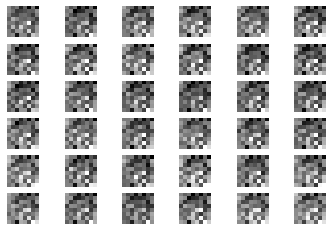

In [8]:
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.axis('off')
    x = network.inner(torch.tensor(X_train[i:i+1]).cuda())
    plt.imshow(x[0].view(8,8).cpu().detach().numpy(), cmap='gray')
plt.show()

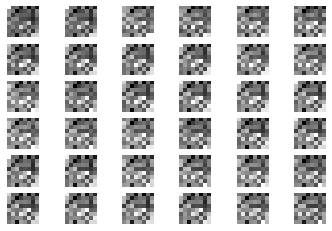

In [9]:
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.axis('off')
    t = network.inner(torch.tensor(mal_x[i:i+1]).cuda())
    plt.imshow(t[0].view(8,8).cpu().detach().numpy(), cmap='gray')
plt.show()

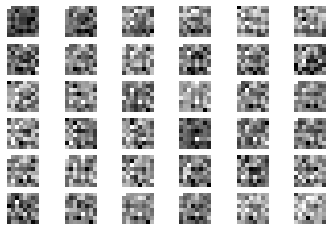

In [10]:
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.axis('off')
    x = network.inner(torch.tensor(X_train[i:i+1]).cuda())
    t = network.inner(torch.tensor(mal_x[i:i+1]).cuda())
    tmp = t-x
    plt.imshow(tmp[0].view(8,8).cpu().detach().numpy(), cmap='gray')
plt.show()